In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ipl-eda/matches_world_eda.pkl
/kaggle/input/ipl-eda/__results__.html
/kaggle/input/ipl-eda/__resultx__.html
/kaggle/input/ipl-eda/__notebook__.ipynb
/kaggle/input/ipl-eda/__output__.json
/kaggle/input/ipl-eda/custom.css
/kaggle/input/ipl-eda/__results___files/__results___8_0.png
/kaggle/input/ipl-eda/__results___files/__results___60_0.png
/kaggle/input/ipl-eda/__results___files/__results___10_0.png
/kaggle/input/ipl-eda/__results___files/__results___51_1.png
/kaggle/input/ipl-eda/__results___files/__results___73_1.png
/kaggle/input/ipl-eda/__results___files/__results___37_0.png
/kaggle/input/ipl-eda/__results___files/__results___71_1.png
/kaggle/input/ipl-eda/__results___files/__results___41_0.png
/kaggle/input/ipl-eda/__results___files/__results___45_1.png
/kaggle/input/ipl-data-set/matches.csv
/kaggle/input/ipl-data-set/teamwise_home_and_away.csv
/kaggle/input/ipl-data-set/deliveries.csv
/kaggle/input/ipl-data-set/most_runs_average_strikerate.csv
/kaggle/input/ipl-data-

In [2]:
base = '/kaggle/input/cleaning/cleaned_out/'
names = ['matches','teamwise_home_and_away','deliveries','most_runs_average_strikerate','teams','players']
for i,name in enumerate(names):
    my_code = name+'='+'pd.read_pickle("'+base+name+'.pkl'+'")'
    exec(my_code)

In [3]:
matches_full = pd.read_pickle("../input/ipl-eda/matches_world_eda.pkl")

## Let's first process some of the featuress we have

In [4]:
cols_to_drop = ["toss_winner","toss_decision",]
for col in cols_to_drop:
    if col in matches_full.columns:
        matches_full.drop(columns=col,inplace=True)

In [5]:
matches_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836 entries, 0 to 755
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               836 non-null    int64         
 1   Season           836 non-null    int64         
 2   city             836 non-null    object        
 3   date             836 non-null    datetime64[ns]
 4   team1            836 non-null    object        
 5   team2            836 non-null    object        
 6   result           836 non-null    object        
 7   dl_applied       836 non-null    int64         
 8   winner           836 non-null    object        
 9   win_by_runs      836 non-null    int64         
 10  win_by_wickets   836 non-null    int64         
 11  player_of_match  836 non-null    object        
 12  venue            836 non-null    object        
 13  umpire1          836 non-null    object        
 14  umpire2          836 non-null    object   

### Next let's apply encoding for the features

> Frequency encoding is useful for features with high cardinality while label encoding is for other columns (in most cases)

In [6]:
cat_columns =  list(matches_full.select_dtypes(include=['object']).columns)
for col in cat_columns:
    print("col {} has {} unique values".format(col,matches_full[col].nunique()))

col city has 33 unique values
col team1 has 15 unique values
col team2 has 15 unique values
col result has 3 unique values
col winner has 16 unique values
col player_of_match has 227 unique values
col venue has 41 unique values
col umpire1 has 62 unique values
col umpire2 has 66 unique values
col umpire3 has 26 unique values
col country has 6 unique values
col duals_sets has 86 unique values


*We can encode the umpires by frequency and others by label_encoder*

In [7]:
matches_engineering = matches_full.copy()

In [8]:
def freq_encode_col(df,col):
    enc_nom_1 = (df.groupby(col).size()) / len(df)
    return df[col].apply(lambda x : enc_nom_1[x])
def freq_encode_cols(df,cols):
    for col in cols:
        df[col] = freq_encode_col(df,col)
    return df

In [9]:
freq_enc_cols = ['umpire1','umpire2','umpire3']
label_enc_cols = [col for col in cat_columns if col not in freq_enc_cols]

In [10]:
labelencoder = LabelEncoder()
for col in label_enc_cols:
    matches_engineering[col] = labelencoder.fit_transform(matches_engineering[col])

In [11]:
matches_engineering = freq_encode_cols(matches_engineering,freq_enc_cols)

In [12]:
matches_engineering.head()

,id,Season,city,date,team1,team2,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,country,population,duals_sets
0,1,2017,15,2017-05-04,14,13,1,0,14,35,0,224,28,0.015550,0.015550,0.840909,1,6810000.0,85
1,2,2017,27,2017-06-04,8,11,1,0,11,0,7,199,21,0.013158,0.076555,0.840909,1,7764000.0,74
2,3,2017,29,2017-07-04,4,7,1,0,7,0,10,34,31,0.026316,0.049043,0.840909,1,1286995.0,24
3,4,2017,16,2017-08-04,11,5,1,0,5,0,6,61,13,0.051435,0.077751,0.840909,1,2201927.0,38
4,5,2017,2,2017-08-04,13,3,1,0,13,15,0,99,17,0.002392,0.002392,0.840909,1,13707000.0,20


In [13]:
matches_engineering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836 entries, 0 to 755
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               836 non-null    int64         
 1   Season           836 non-null    int64         
 2   city             836 non-null    int64         
 3   date             836 non-null    datetime64[ns]
 4   team1            836 non-null    int64         
 5   team2            836 non-null    int64         
 6   result           836 non-null    int64         
 7   dl_applied       836 non-null    int64         
 8   winner           836 non-null    int64         
 9   win_by_runs      836 non-null    int64         
 10  win_by_wickets   836 non-null    int64         
 11  player_of_match  836 non-null    int64         
 12  venue            836 non-null    int64         
 13  umpire1          836 non-null    float64       
 14  umpire2          836 non-null    float64  

# Let's list our new features (inspired from EDA):
    * number of previous matches per pair teams
    * percentage of exponential weighted average of
        * previous matches played in a country (team1 vs team2)
        * previous matches won in a country (team1 vs team2)
        * previous matches played in a city (team1 vs team2)
        * previous matches won in a city (team1 vs team2)
        * previous winned matches 
        * previous winned matches per season
        * previous win rate matches per season
        * win rate of team1 vs team 2

In [14]:
matches_play = matches_engineering.copy()


In [15]:
matches_play_t1 = matches_play.drop(columns='team2').rename(columns={'team1':'team'})
win_index = list(matches_play_t1.columns).index('winner')
team_index = list(matches_play_t1.columns).index('team')
matches_play_t1['winner'] = matches_play_t1.apply(lambda x:int(x[win_index]==x[team_index]),axis=1)

In [16]:
matches_play_t2 = matches_play.drop(columns='team1').rename(columns={'team2':'team'})
win_index = list(matches_play_t1.columns).index('winner')
team_index = list(matches_play_t1.columns).index('team')
matches_play_t2['winner'] = matches_play_t2.apply(lambda x:int(x[win_index]==x[team_index]),axis=1)

In [17]:
matches_play_t1_t2 = matches_play_t1.append(matches_play_t2, ignore_index=True)
matches_play_t1_t2.sort_values(by='date',axis=0,inplace=True)

### Let's see the moving average and the rolling (for means, sums and stds) to see which gives more variablility

<AxesSubplot:xlabel='date'>

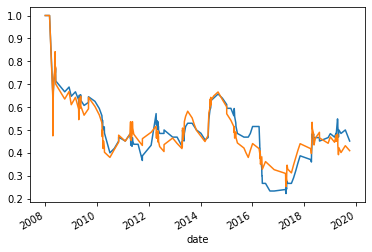

In [18]:
df = matches_play_t1_t2.copy()
df = df.set_index(['date'])
years_num = 2
years_days = str(years_num*12*30)
k1 = df.groupby('team').rolling(years_days+'D')['winner'].mean()
k2 = df.groupby('team')['winner'].ewm(alpha=0.05).mean()
k1[5].plot()
k2[5].plot()

In [19]:
k1

team  date      
0     2008-01-06    0.000000
      2008-02-05    0.000000
      2008-04-05    0.000000
      2008-04-19    0.250000
      2008-04-23    0.400000
                      ...   
14    2019-04-27    0.555556
      2019-04-29    0.567568
      2019-06-04    0.571429
      2019-08-04    0.542857
      2019-08-05    0.527778
Name: winner, Length: 1672, dtype: float64

<AxesSubplot:xlabel='date'>

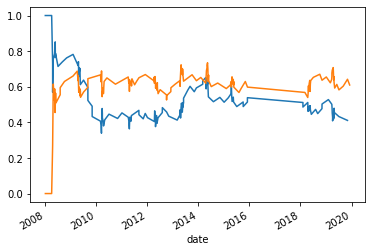

In [20]:
k2[10].plot()
k2[0].plot()

> We can see that the data is noisy at first (as we are dealing with binary data), but the ewm shows the details more

<AxesSubplot:xlabel='date'>

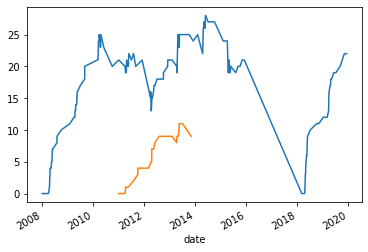

In [21]:
k1 = df.groupby('team').rolling(years_days+'D')['winner'].sum()
k1[0].plot()
k1[9].plot()

<AxesSubplot:xlabel='date'>

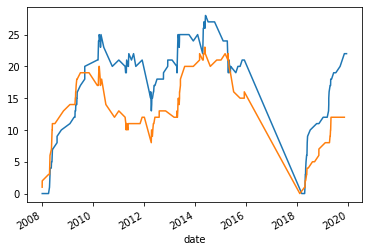

In [22]:
k1[0].plot()
k1[10].plot()

> The sum shows the same trend for the different teams (with different levels), and help distingush those who appears on random time periods

> but we have the problem of having values in the first period not very reliable, so we will work with ratios between the two teams (we may try to truncate season 2008 too)

<AxesSubplot:xlabel='date'>

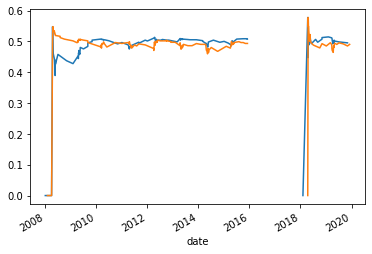

In [23]:
k1 = df.groupby('team').rolling(years_days+'D')['winner'].std()
k1[10].plot()
k1[0].plot()

> The std for the teams is parely 0.5 for all teams (binary data), so we may calculate the std of the ewm (or sum) of the calculated features

In [24]:
k1 = df.groupby('team').rolling(years_days+'D')['winner'].sum()

<AxesSubplot:xlabel='date'>

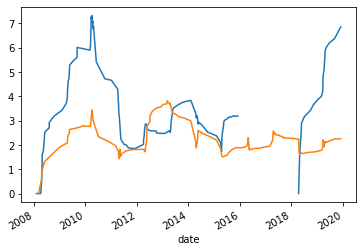

In [25]:
k1 = df.groupby('team').rolling(years_days+'D')['winner'].sum()
k1 = k1.reset_index()
k1 = k1.set_index('date')
k2 = k1.groupby('team')['winner'].rolling(years_days+'D').std()
k2[0].plot()
k2[7].plot()

> Now this may be a good feature

> Places with discontinuities are for some teams that stopped playing for two seasons then returned

### let's check the duals win rate

In [26]:
df = matches_play_t1.copy()
df = df.set_index('date')
years_num = 2
years_days = str(years_num*12*30)
k1 = df.groupby('duals_sets')['winner'].ewm(alpha=0.05).mean()

In [27]:
df = matches_play_t2.copy()
df = df.set_index('date')
k2 = df.groupby('duals_sets')['winner'].ewm(alpha=0.05).mean()

<AxesSubplot:xlabel='date'>

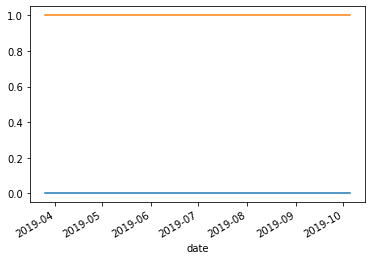

In [28]:
k1[0].plot()
k2[0].plot()

<AxesSubplot:xlabel='date'>

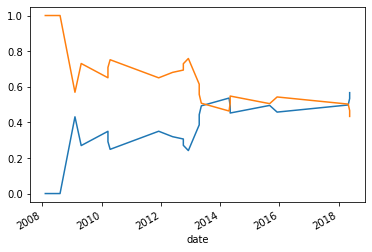

In [29]:
k1[1].plot()
k2[1].plot()

> Some teams becomes better against other teams with time (this may gives good info for the model)

<AxesSubplot:xlabel='date'>

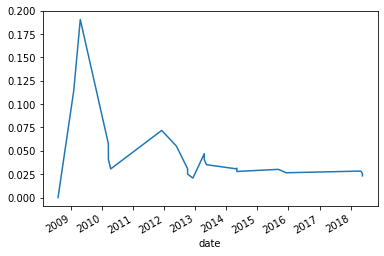

In [30]:
k1[1].rolling(years_num).std().plot()

> The std will give info about how will the statistic we are using is reliable

In [31]:
k1 = k1.reset_index()
k1

,duals_sets,date,winner
0,0,2019-03-26,0.000000
1,0,2019-03-26,0.000000
2,0,2019-10-05,0.000000
3,1,2008-02-05,0.000000
4,1,2008-08-05,0.000000
...,...,...,...
831,85,2016-05-29,0.433973
832,85,2018-07-05,0.499607
833,85,2018-05-17,0.554040
834,85,2019-03-31,0.599859


In [32]:
df1 = df.reset_index()

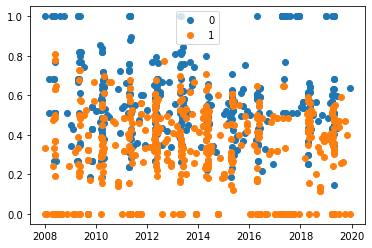

In [33]:
df2 = df1.merge(k1, on=['duals_sets','date'])
groups = df2.groupby("winner_x")
for name, group in groups:
    plt.plot(group["date"], group["winner_y"], marker="o", linestyle="", label=name)
plt.legend()

In [34]:
df = matches_play_t1.copy()
df = df.set_index('date')
years_num = 2
years_days = str(years_num*12*30)
k1 = df.groupby(['duals_sets','city'])['winner'].ewm(alpha=0.05).mean()

In [35]:
k1 = k1.reset_index()
k1.head()

,duals_sets,city,date,winner
0,0,10,2019-03-26,0.0
1,0,10,2019-03-26,0.0
2,0,32,2019-10-05,0.0
3,1,0,2014-04-21,1.0
4,1,8,2008-02-05,0.0


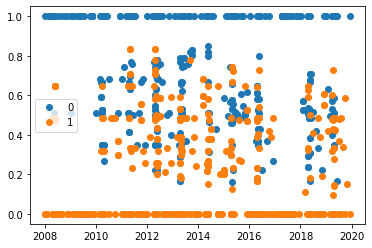

In [36]:
df2 = df1.merge(k1, on=['duals_sets','date'])
groups = df2.groupby("winner_x")
for name, group in groups:
    plt.plot(group["date"], group["winner_y"], marker="o", linestyle="", label=name)
plt.legend()

> We can see a great seperator here when grouping by country too
> It looks like many small teams playing in some countries for the first time are not match for other teams who play in these countries always

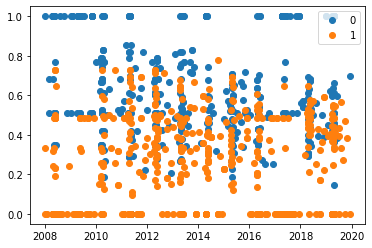

In [37]:
df = matches_play_t1.copy()
df = df.set_index('date')
years_num = 2
years_days = str(years_num*12*30)
k1 = df.groupby(['duals_sets','country'])['winner'].ewm(alpha=0.05).mean()

k1 = k1.reset_index()
df2 = df1.merge(k1, on=['duals_sets','date'])
groups = df2.groupby("winner_x")
for name, group in groups:
    plt.plot(group["date"], group["winner_y"], marker="o", linestyle="", label=name)
plt.legend()

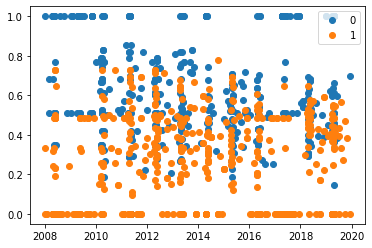

In [38]:
df = matches_play_t1.copy()
df = df.set_index(['date','id'])
years_num = 2
years_days = str(years_num*12*30)
k1 = df.groupby(['duals_sets','country'])['winner'].ewm(alpha=0.05).mean()

k1 = k1.reset_index()
df2 = df1.merge(k1, on=['duals_sets','date'])
groups = df2.groupby("winner_x")
for name, group in groups:
    plt.plot(group["date"], group["winner_y"], marker="o", linestyle="", label=name)
plt.legend()

In [39]:
df = matches_play_t1.copy()


In [40]:
matches_play_t1.date.nunique()

546

In [41]:
def get_same_day_matches_id(s):
    k = np.arange(len(s))
    return k
def add_same_day_mathches_id(df,group_cols):
    cols = list(df.columns)
    for c in group_cols:
        cols.remove(c)
    col = cols[0]
    return df.groupby(group_cols)[col].transform(get_same_day_matches_id).values

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='same_day_mathches_id', ylabel='count'>

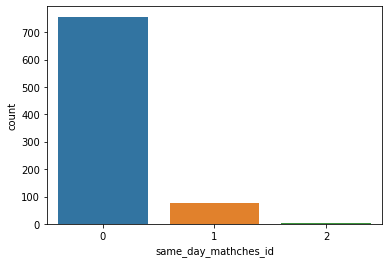

In [42]:
matches_play_t1['same_day_mathches_id'] = add_same_day_mathches_id(matches_play_t1,['duals_sets','date'])
sns.countplot(matches_play_t1['same_day_mathches_id'])

In [43]:
def create_rolling_feat(df,groups_input,roll_col,col_name,key_cols,is_ewm=True,func_to_apply='mean',years_num=2,alpha=0.05):
    # preprcess the dataframe
    df_input = df.copy()
    df_input = df_input.set_index('date')
    groups = deepcopy(groups_input)
    years_days = str(years_num*12*30)
    # get the group
    if is_ewm:
        k1 = df_input.groupby(groups)[roll_col].ewm(alpha=alpha)
    else:
        k1 = df_input.groupby(groups).rolling(years_days+'D')[roll_col]
    # apply the function
    if func_to_apply == 'mean':
        k1 = k1.mean()
    elif func_to_apply == 'sum':
        k1 = k1.sum()
    elif func_to_apply == 'std':
        k1 = k1.std()
    
    k1.name = col_name
    # prepare df to merge
    df_input = df_input.reset_index()
    groups.extend(['date','same_day_mathches_id'])
    # prepare k1 to merge
    k1 = k1.reset_index()
    k1 ['same_day_mathches_id'] = add_same_day_mathches_id(k1,key_cols)
    # merge
#     print(df_input.columns)
#     print(k1.columns)
    df_input = df_input.merge(k1,how='left', on=groups)
#     print(df_input.shape)
    
    return df_input
    

In [44]:
from copy import deepcopy
roll_col = 'winner'
groups_cols = [['country'],['venue'],['city'],['Season']]
groups_cols1 =deepcopy(groups_cols)
[e.insert(0,'duals_sets')for e in groups_cols1]
# groups_cols1.append(['duals_sets'])
groups_cols1

[['duals_sets', 'country'],
 ['duals_sets', 'venue'],
 ['duals_sets', 'city'],
 ['duals_sets', 'Season']]

In [45]:
k = len(groups_cols1)
groups_cols2 = deepcopy(groups_cols1)
for i in range(k):
    ele = groups_cols2[i]
    ele[0] = 'team'
    groups_cols1.append(ele)
groups_cols1    

[['duals_sets', 'country'],
 ['duals_sets', 'venue'],
 ['duals_sets', 'city'],
 ['duals_sets', 'Season'],
 ['team', 'country'],
 ['team', 'venue'],
 ['team', 'city'],
 ['team', 'Season']]

In [46]:
groups_cols1.extend([['duals_sets'],['team']])

In [47]:
df = matches_play_t1.copy()



for group in groups_cols1:
    roll_col = 'winner'
    # ewm mean columns
    if group[0] == 'team':
        key_cols = ['team','date']
    else:
        key_cols = ['duals_sets','date']
    new_col = '_'.join(group)+'_ewm_mean'
    df = create_rolling_feat(df,group,roll_col,new_col,key_cols)
    for i in [1,2,3,4]:
        new_col = '_'.join(group)+'_sum_'+str(i)
        df = create_rolling_feat(df,group,roll_col,new_col,key_cols,is_ewm=False,func_to_apply='sum',years_num=i)
        
        
    
    


In [48]:
df = df.T.drop_duplicates().T
df.head()

,date,id,Season,city,team,result,dl_applied,winner,win_by_runs,win_by_wickets,...,duals_sets_ewm_mean,duals_sets_sum_1,duals_sets_sum_2,duals_sets_sum_3,duals_sets_sum_4,team_ewm_mean,team_sum_1,team_sum_2,team_sum_3,team_sum_4
0,2017-05-04,1,2017,15,14,1,0,1,35,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2017-06-04,2,2017,27,8,1,0,0,0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-07-04,3,2017,29,4,1,0,0,0,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-08-04,4,2017,16,11,1,0,0,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-08-04,5,2017,2,13,1,0,1,15,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [49]:
df

,date,id,Season,city,team,result,dl_applied,winner,win_by_runs,win_by_wickets,...,duals_sets_ewm_mean,duals_sets_sum_1,duals_sets_sum_2,duals_sets_sum_3,duals_sets_sum_4,team_ewm_mean,team_sum_1,team_sum_2,team_sum_3,team_sum_4
0,2017-05-04,1,2017,15,14,1,0,1,35,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2017-06-04,2,2017,27,8,1,0,0,0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-07-04,3,2017,29,4,1,0,0,0,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-08-04,4,2017,16,11,1,0,0,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-08-04,5,2017,2,13,1,0,1,15,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,2019-05-05,11347,2019,24,7,1,0,0,0,9,...,0.471179,3.0,11.0,11.0,11.0,0.363861,2.0,5.0,35.0,35.0
832,2019-07-05,11412,2019,8,0,1,0,0,0,6,...,0.439702,0.0,0.0,0.0,0.0,0.540841,3.0,6.0,6.0,13.0
833,2019-08-05,11413,2019,32,14,1,0,0,0,2,...,0.256073,1.0,1.0,1.0,1.0,0.431087,2.0,30.0,31.0,31.0
834,2019-10-05,11414,2019,32,2,1,0,0,0,6,...,0.0,0.0,0.0,0.0,0.0,0.456158,4.0,4.0,4.0,4.0


In [50]:
df.to_csv('matches_fat_eng.csv')